**Aluno: Leonardo Ribeiro Schaedler**

# Atividade Spark SQL e Visualização

Considerando o dataset detalhado a seguir, extraia o conjunto de informações solicitadas.

### Dataset dados de COVID no Brasil

- Dados relativos a pacientes que realizaram exames de Covid19 no Brasil
- ~1.6GB
- 4.4M de instâncias


|  # | Nome do campo        	| Descrição                                     	|
|----|----------------------	|-----------------------------------------------	|
|  0 | id                   	| identificador                                 	|
|  1 | dataNotificacao      	| Data da notificação                           	|
|  2 | dataInicioSintomas   	| Data do inicio dos sintomas                   	|
|  3 | dataNascimento       	| Data de nascimento                            	|
|  4 | sintomas             	| Sintomas do paciente                          	|
|  5 | profissionalSaude    	| Relacionado a profissional de saúde           	|
|  6 | cbo                  	| Ocupação                                      	|
|  7 | condicoes            	| Condições do paciente                         	|
|  8 | estadoTeste          	| Estado do teste                               	|
|  9 | dataTeste            	| Data do teste                                 	|
| 10 | tipoTeste            	| Tipo de teste realizado                       	|
| 11 | resultadoTeste       	| Resultado do Teste                            	|
| 12 | paisOrigem           	| Pais de Origem do paciente                    	|
| 13 | sexo                 	| Sexo do paciente                              	|
| 14 | bairro               	| Bairro do paciente                            	|
| 15 | estado               	| Estado do paciente                            	|
| 16 | estadoIBGE              	| Estado do paciente IBGE                          	|
| 17 | municipio            	| Municipio do paciente                         	|
| 18 | municipioIBGE          	| Municipio do paciente                         	|
| 19 | cep            	        | CEP                                            	|
| 20 | origem               	| Origem do paciente                            	|
| 21 | cnes                 	| Código da unidade de saúde                    	|
| 22 | estadoNotificacao    	| Estado da notificação                         	|
| 23 | estadoNotificacaoIBGE    | Estado da notificação IBGE                      	|
| 24 | municipioNotificacao 	| Município da notificação                      	|
| 25 | municipioNotificacaoIBGE | Município da notificação IBGE                    	|
| 26 | numeroNotificacao    	| Número da notificação                         	|
| 27 | excluido             	| ID de exclusão                                	|
| 28 | validado             	| Local validação                               	|
| 29 | idade                	| Idade do paciente                             	|
| 30 | dataEncerramento     	| Data do encerramento da avaliação do paciente 	|
| 31 | evolucaoCaso         	| Evolução do caso do paciente                  	|
| 32 | classificacaoFinal   	| Avaliação final do caso                       	|

Informações a serem extraídas:

1. Gráfico exibindo os 10 sintomas mais comuns para casos positivos para corona virus
2. Gráfico da quantidade de pacientes com exames realizados ao longo do tempo
3. Gráfico da quantidade de pacientes positivos para corona virus (resultadoTeste) no PARANÁ
4. Gráfico da quantidade de pacientes positivos para corona virus (resultadoTeste) em Curitiba
5. Gráfico da quantidade de pacientes de Curitiba de acordo com o bairro
6. Gráfico comparando quantidade de pacientes positivos para corona virus (resultadoTeste) no PARANÁ e SANTA CATARINA ao longo dos dias
7. Gráfico comparando quantidade de pacientes que vieram a óbito (evolucaoCaso) no PARANÁ e SANTA CATARINA ao longo dos dias
8. Gráfico comparando os 10 sintomas mais comuns entre casos positivos e não positivos para corona virus
9. Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ e em SANTA CATARINA
10. Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ de acordo com o sexo
11. Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ de acordo com a evolução do caso

In [125]:
#instala pyspark no google colab
!pip install pyspark==3.3.1

In [126]:
# abre sessão no spark sql
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
import matplotlib.pyplot as plt

sc = SparkSession \
    .builder \
    .master('local[*]') \
    .getOrCreate()

In [127]:
#Efetua download do arquivo covid
!gdown 1EYMih3Ys1-DmaIZ9n0Sl5KAcRGqtpuj9

Downloading...
From: https://drive.google.com/uc?id=1EYMih3Ys1-DmaIZ9n0Sl5KAcRGqtpuj9
To: /content/covid.csv
100% 1.64G/1.64G [00:26<00:00, 61.7MB/s]


In [128]:
df = sc.read \
    .option('delimiter', ';') \
    .option('header', 'true') \
    .option('inferschema', 'true') \
    .csv('file:////content/covid.csv')

In [129]:
#informacao 1 - Gráfico exibindo os 10 sintomas mais comuns para casos positivos para corona virus

In [130]:
df.select('sintomas').show(5, truncate=False)

+---------------------------------+
|sintomas                         |
+---------------------------------+
|Dor de Garganta                  |
|Dispneia, Outros, Dor de Garganta|
|Outros                           |
|Dispneia, Febre, Tosse           |
|Outros                           |
+---------------------------------+
only showing top 5 rows



In [131]:
from pyspark.sql import functions as func

top10_sintomas = df.filter(df.resultadoTeste == 'Positivo') \
  .withColumn('Sintoma', func.explode(func.split(func.col('sintomas'), ','))) \
  .groupBy('Sintoma') \
  .count() \
  .orderBy('count', ascending=False) \
  .limit(10)

top10_sintomas.show()

+----------------+------+
|         Sintoma| count|
+----------------+------+
|          Outros|438768|
|          Outros|402820|
|           Febre|349057|
|           Tosse|307669|
|           Tosse|268506|
| Dor de Garganta|189224|
|        Dispneia|142398|
|           Febre|113030|
| Dor de Garganta| 99457|
|        Dispneia| 42908|
+----------------+------+



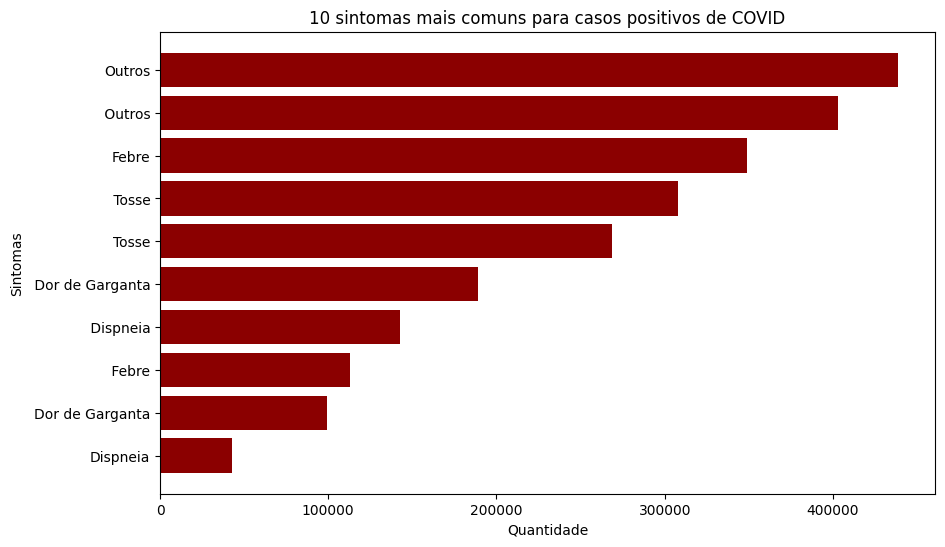

In [132]:
import matplotlib.pyplot as plt
import pandas as pd

top10_sintomas_pd = top10_sintomas.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top10_sintomas_pd['Sintoma'], top10_sintomas_pd['count'], color='darkred')
plt.xlabel('Quantidade')
plt.ylabel('Sintomas')
plt.title('10 sintomas mais comuns para casos positivos de COVID')
plt.gca().invert_yaxis()
plt.show()

In [133]:
#informacao 2 - Gráfico da quantidade de pacientes com exames realizados ao longo do tempo

In [134]:
testes_tempo = df.groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')
testes_tempo.show()

+-------------------+-----+
|          dataTeste|count|
+-------------------+-----+
|2020-01-01 02:00:00|    1|
|2020-01-01 03:00:00|   39|
|2020-01-02 03:00:00|    9|
|2020-01-03 03:00:00|    5|
|2020-01-04 03:00:00|    3|
|2020-01-05 03:00:00|    9|
|2020-01-06 03:00:00|   11|
|2020-01-07 03:00:00|   23|
|2020-01-07 12:00:00|    1|
|2020-01-08 03:00:00|   10|
|2020-01-09 03:00:00|    4|
|2020-01-10 03:00:00|    7|
|2020-01-11 02:00:00|    1|
|2020-01-11 03:00:00|    3|
|2020-01-12 03:00:00|    3|
|2020-01-13 02:00:00|    2|
|2020-01-13 03:00:00|    5|
|2020-01-14 03:00:00|    4|
|2020-01-15 03:00:00|   18|
|2020-01-16 03:00:00|    6|
+-------------------+-----+
only showing top 20 rows



/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


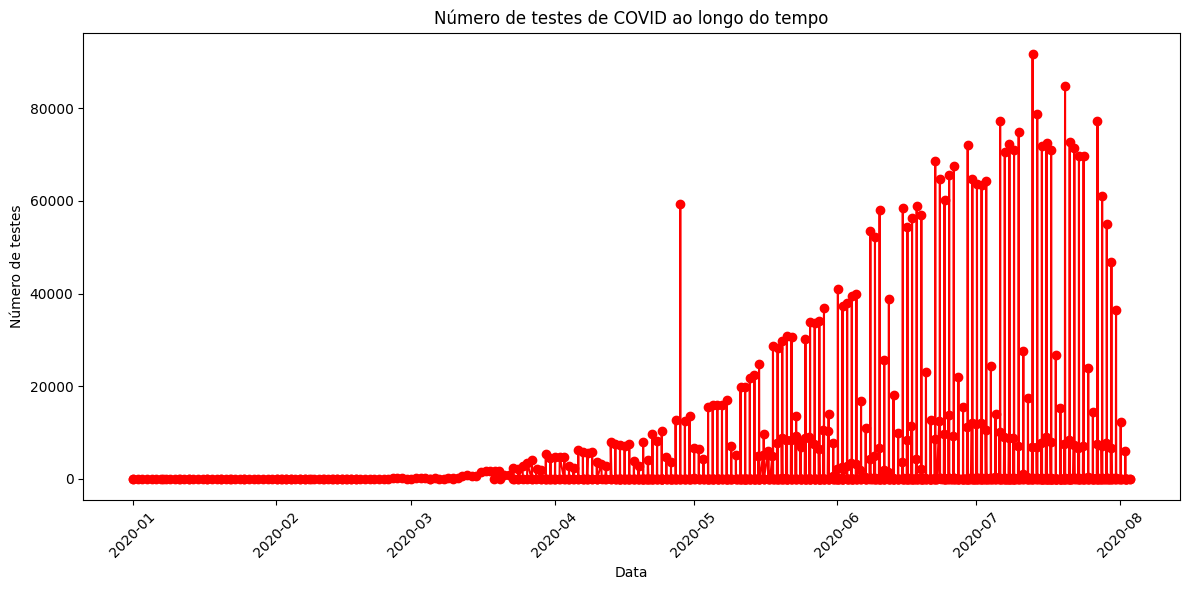

In [135]:
teste_count_pd = testes_tempo.toPandas()

teste_count_pd['dataTeste'] = pd.to_datetime(teste_count_pd['dataTeste'])

plt.figure(figsize=(12, 6))
plt.plot(teste_count_pd['dataTeste'], teste_count_pd['count'], marker='o', color='r')
plt.xlabel('Data')
plt.ylabel('Número de testes')
plt.title('Número de testes de COVID ao longo do tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [136]:
#informacao 3 - Gráfico da quantidade de pacientes positivos para corona virus (resultadoTeste) no PARANÁ

In [137]:
parana_positivo = df.filter((df.resultadoTeste == 'Positivo') & (df.estado == 'PARANÁ')) \
  .count()

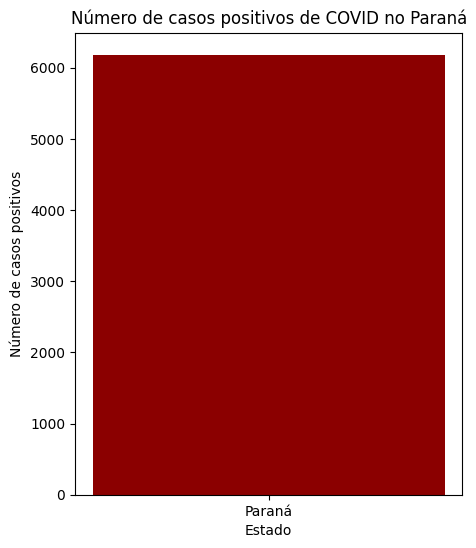

In [138]:
parana_positivo = df.filter((df.resultadoTeste == 'Positivo') & (df.estado == 'PARANÁ')).count()

plt.figure(figsize=(5, 6))
plt.bar('Paraná', parana_positivo, color='darkred')
plt.xlabel('Estado')
plt.ylabel('Número de casos positivos')
plt.title('Número de casos positivos de COVID no Paraná')
plt.show()

**Ao longo do tempo**

In [139]:
parana_positivo_tempo = df.filter((df.resultadoTeste == 'Positivo') & (df.estado == 'PARANÁ')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


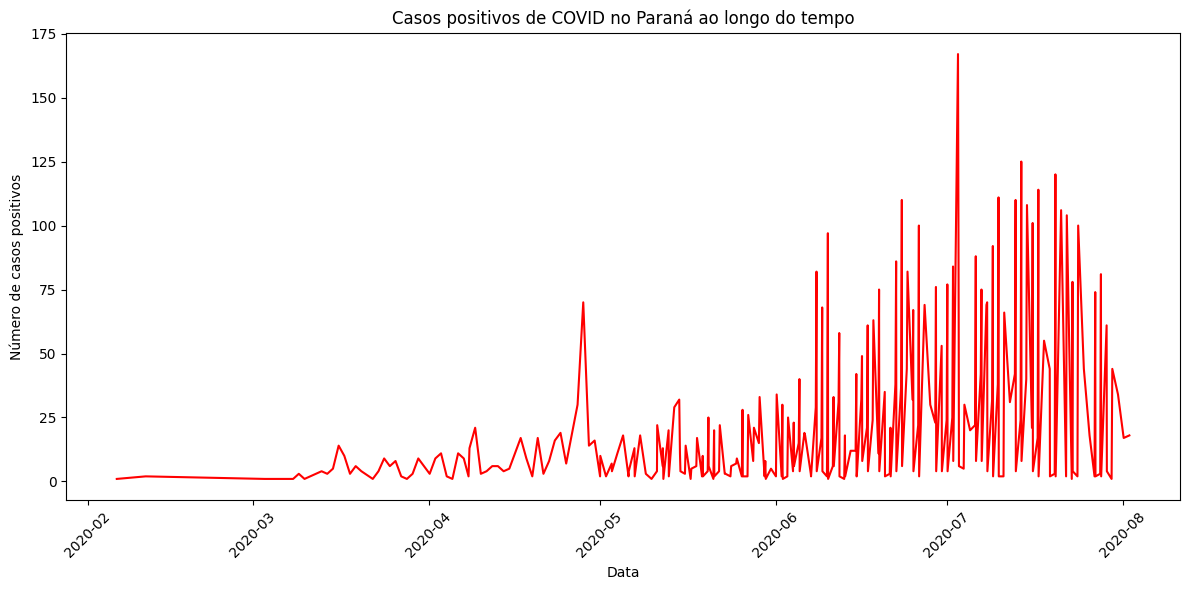

In [140]:
parana_pd = parana_positivo_tempo.toPandas()

parana_pd['dataTeste'] = pd.to_datetime(parana_pd['dataTeste'])

plt.figure(figsize=(12, 6))
plt.plot(parana_pd['dataTeste'], parana_pd['count'], label='Paraná', color='red')
plt.xlabel('Data')
plt.ylabel('Número de casos positivos')
plt.title('Casos positivos de COVID no Paraná ao longo do tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [141]:
#informacao 4 - Gráfico da quantidade de pacientes positivos para corona virus (resultadoTeste) em Curitiba

In [142]:
curitiba_positivo = df.filter((df.resultadoTeste == 'Positivo') & (df.municipio == 'Curitiba')).count()

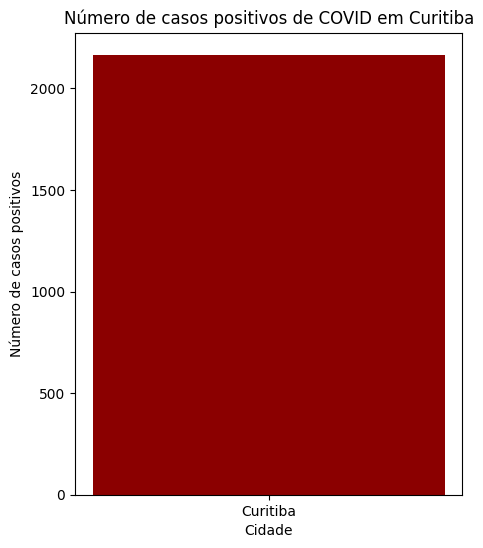

In [143]:
plt.figure(figsize=(5, 6))
plt.bar('Curitiba', curitiba_positivo, color='darkred')
plt.xlabel('Cidade')
plt.ylabel('Número de casos positivos')
plt.title('Número de casos positivos de COVID em Curitiba')
plt.show()

**Ao longo do tempo**

In [144]:
curitiba_positivo_tempo = df.filter((df.resultadoTeste == 'Positivo') & (df.municipio == 'Curitiba')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


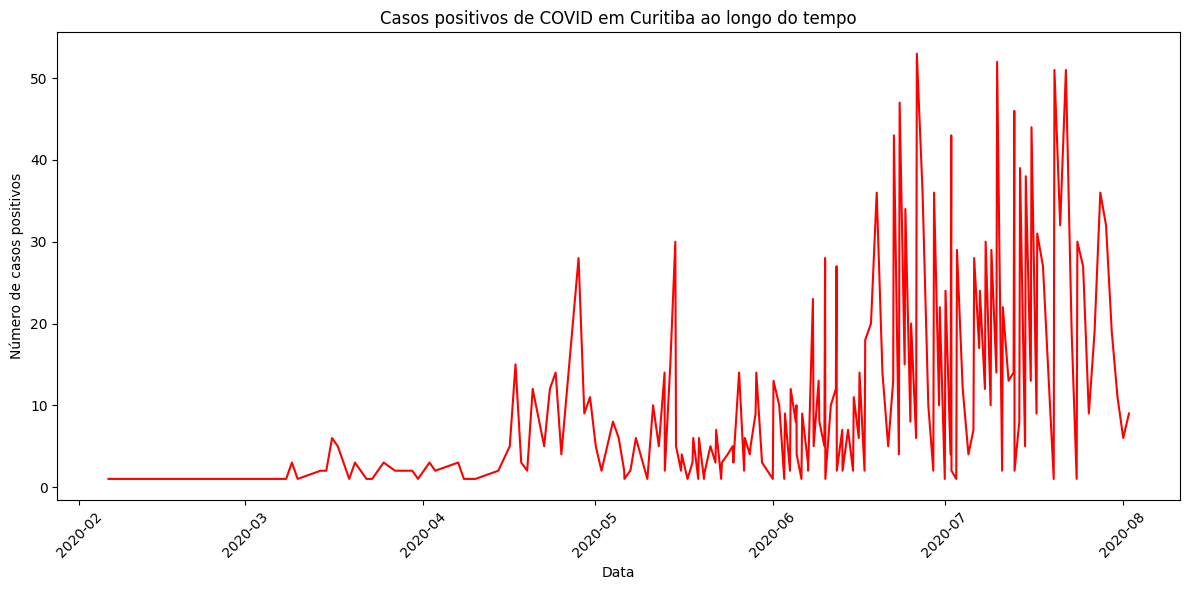

In [145]:
curitiba_pd = curitiba_positivo_tempo.toPandas()

curitiba_pd['dataTeste'] = pd.to_datetime(curitiba_pd['dataTeste'])

plt.figure(figsize=(12, 6))
plt.plot(curitiba_pd['dataTeste'], curitiba_pd['count'], label='Curitiba', color='red')
plt.xlabel('Data')
plt.ylabel('Número de casos positivos')
plt.title('Casos positivos de COVID em Curitiba ao longo do tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:
#informacao 5 - Gráfico da quantidade de pacientes de Curitiba de acordo com o bairro

In [147]:
pacientes_bairro = df.filter(df.municipio == 'Curitiba') \
  .groupBy('bairro') \
  .count() \
  .orderBy('count', ascending=False)

pacientes_bairro.show()

+-----------------+-----+
|           bairro|count|
+-----------------+-----+
|             null|  809|
|    Sítio Cercado|  423|
|Cidade Industrial|  381|
|CIDADE INDUSTRIAL|  256|
|          UBERABA|  251|
|           CENTRO|  233|
|           CAJURU|  230|
|       AGUA VERDE|  215|
|    SITIO CERCADO|  190|
|        Boqueirão|  145|
|           PORTAO|  135|
|       NOVO MUNDO|  132|
|            XAXIM|  129|
|        BOQUEIRAO|  126|
|      BAIRRO ALTO|  119|
|       BIGORRILHO|  118|
|            Xaxim|  111|
|            BATEL|  110|
|      PINHEIRINHO|  104|
|          Uberaba|  103|
+-----------------+-----+
only showing top 20 rows



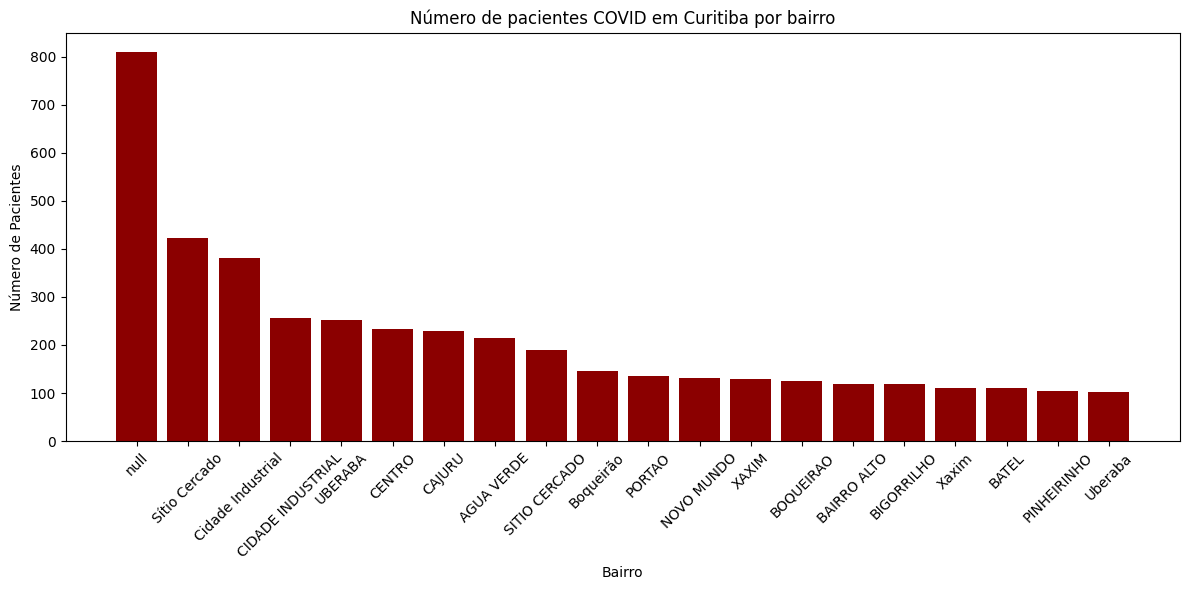

In [148]:
bairros_pd = pacientes_bairro.toPandas()

parte_bairros = bairros_pd.head(20)

plt.figure(figsize=(12, 6))
plt.bar(parte_bairros['bairro'], parte_bairros['count'], color='darkred')
plt.xlabel('Bairro')
plt.ylabel('Número de Pacientes')
plt.title('Número de pacientes COVID em Curitiba por bairro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [149]:
#informacao 6 - Gráfico comparando quantidade de pacientes positivos para corona virus (resultadoTeste) no PARANÁ e SANTA CATARINA ao longo dos dias

In [150]:
parana_positivo_tempo = df.filter((df.resultadoTeste == 'Positivo') & (df.estado == 'PARANÁ')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')

sc_positivo_tempo  = df.filter((df.resultadoTeste == 'Positivo') & (df.estado == 'SANTA CATARINA')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


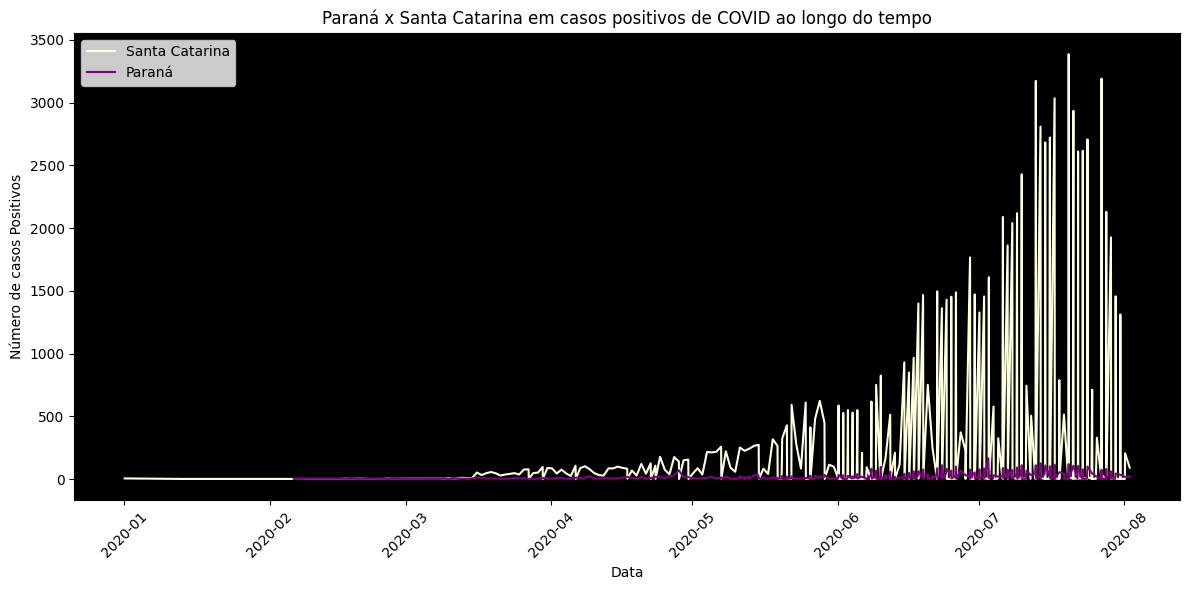

In [151]:
parana_pd = parana_positivo_tempo .toPandas()
santa_catarina_pd = sc_positivo_tempo.toPandas()

parana_pd['dataTeste'] = pd.to_datetime(parana_pd['dataTeste'])
santa_catarina_pd['dataTeste'] = pd.to_datetime(santa_catarina_pd['dataTeste'])

plt.figure(figsize=(12, 6))

plt.gca().set_facecolor('black')
plt.plot(santa_catarina_pd['dataTeste'], santa_catarina_pd['count'], label='Santa Catarina', color='lightyellow')
plt.plot(parana_pd['dataTeste'], parana_pd['count'], label='Paraná', color='purple')

plt.xlabel('Data')
plt.ylabel('Número de casos Positivos')
plt.title('Paraná x Santa Catarina em casos positivos de COVID ao longo do tempo')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [152]:
#informacao 7 - Gráfico comparando quantidade de pacientes que vieram a óbito (evolucaoCaso) no PARANÁ e SANTA CATARINA ao longo dos dias

In [153]:
parana_obitos = df.filter((df.evolucaoCaso == 'Óbito') & (df.estado == 'PARANÁ')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')

sc_obitos = df.filter((df.evolucaoCaso == 'Óbito') & (df.estado == 'SANTA CATARINA')) \
  .groupBy('dataTeste') \
  .count() \
  .orderBy('dataTeste')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


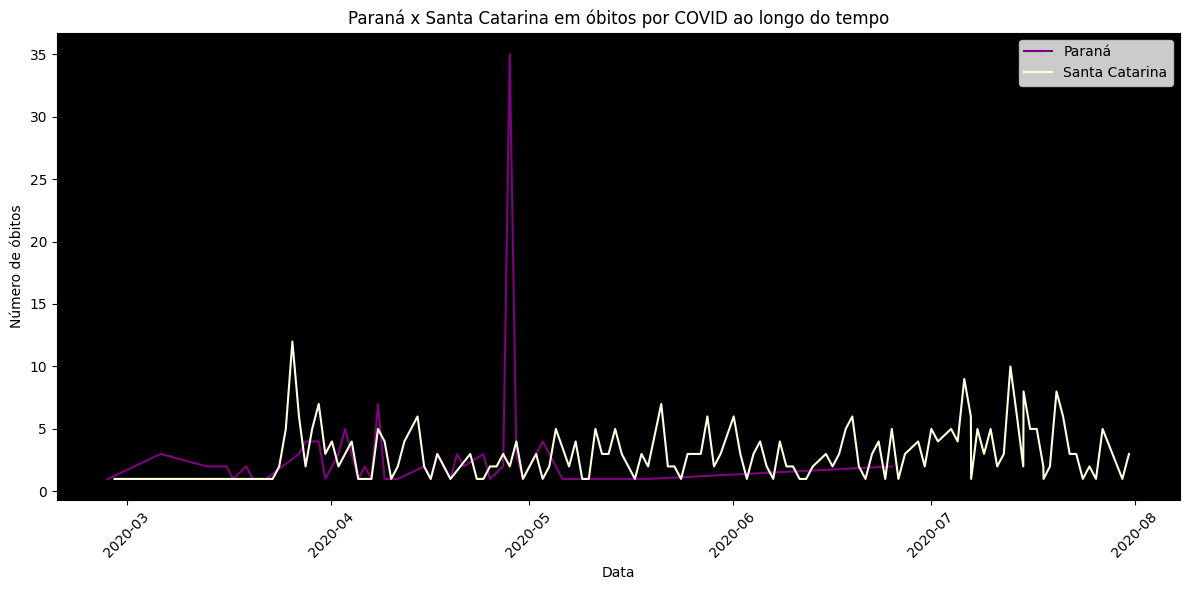

In [154]:
parana_obitos_pd = parana_obitos.toPandas()
sc_obitos_pd = sc_obitos.toPandas()

parana_obitos_pd['dataTeste'] = pd.to_datetime(parana_obitos_pd['dataTeste'])
sc_obitos_pd['dataTeste'] = pd.to_datetime(sc_obitos_pd['dataTeste'])

plt.figure(figsize=(12, 6))
plt.gca().set_facecolor('black')

plt.plot(parana_obitos_pd['dataTeste'], parana_obitos_pd['count'], label='Paraná', color='purple')
plt.plot(sc_obitos_pd['dataTeste'], sc_obitos_pd['count'], label='Santa Catarina', color='lightyellow')

plt.xlabel('Data')
plt.ylabel('Número de óbitos')
plt.title('Paraná x Santa Catarina em óbitos por COVID ao longo do tempo')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [155]:
#informacao 8 - Gráfico comparando os 10 sintomas mais comuns entre casos positivos e não positivos para corona virus

In [156]:
sintomas_positivo = df.filter(df.resultadoTeste == 'Positivo') \
  .withColumn('Sintoma', func.explode(func.split(func.col('sintomas'), ','))) \
  .groupBy('Sintoma') \
  .count() \
  .orderBy('count', ascending=False) \
  .limit(10)

sintomas_nao_positivo = df.filter(df.resultadoTeste != 'Positivo') \
  .withColumn('Sintoma', func.explode(func.split(func.col('sintomas'), ','))) \
  .groupBy('Sintoma') \
  .count() \
  .orderBy('count', ascending=False) \
  .limit(10)

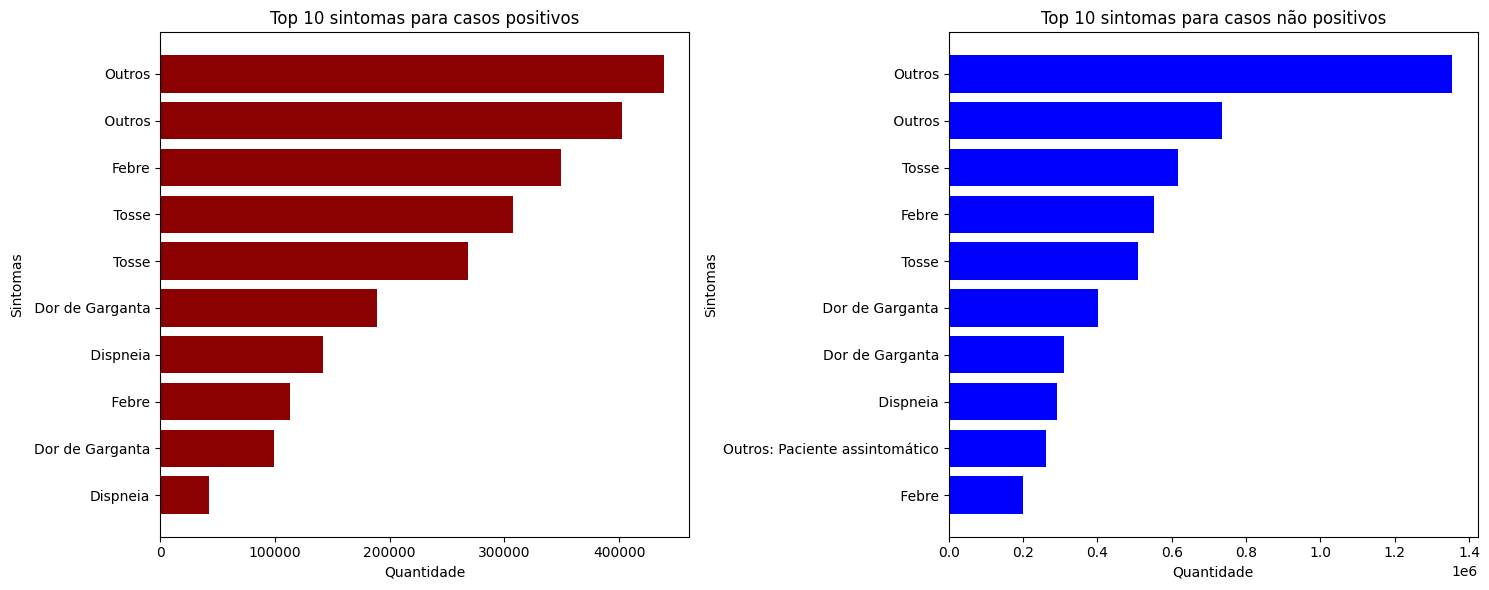

In [157]:
sintomas_positivo_pd = sintomas_positivo.toPandas()
sintomas_nao_positivo_pd = sintomas_nao_positivo.toPandas()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].barh(sintomas_positivo_pd['Sintoma'], sintomas_positivo_pd['count'], color='darkred')
axes[0].set_title('Top 10 sintomas para casos positivos')
axes[0].set_xlabel('Quantidade')
axes[0].set_ylabel('Sintomas')
axes[0].invert_yaxis()

axes[1].barh(sintomas_nao_positivo_pd['Sintoma'], sintomas_nao_positivo_pd['count'], color='blue')
axes[1].set_title('Top 10 sintomas para casos não positivos')
axes[1].set_xlabel('Quantidade')
axes[1].set_ylabel('Sintomas')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [158]:
#informacao 9 - Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ e em SANTA CATARINA

In [159]:
parana_idade_media = df.filter(df.estado == 'PARANÁ') \
  .agg(func.avg('idade').alias('idadeMedia'))

sc_idade_media = df.filter(df.estado == 'SANTA CATARINA') \
  .agg(func.avg('idade').alias('idadeMedia'))

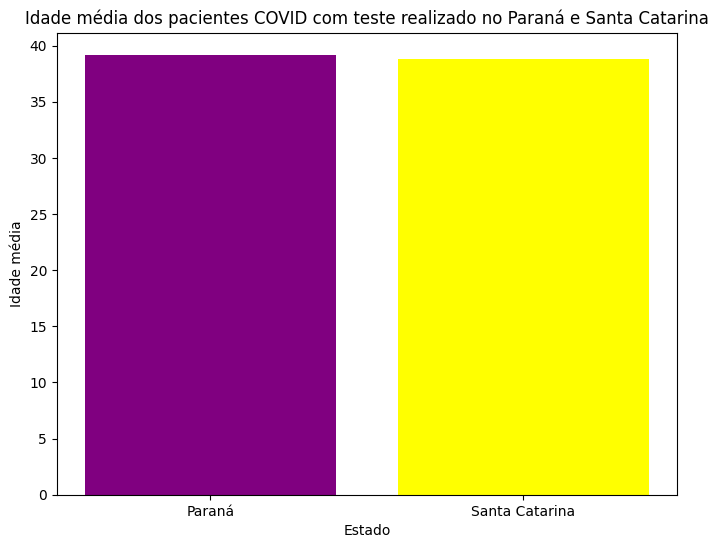

In [160]:
parana_idade_media_pd = parana_idade_media.toPandas()['idadeMedia'][0]
sc_idade_media_pd = sc_idade_media.toPandas()['idadeMedia'][0]

states = ['Paraná', 'Santa Catarina']
pds = [parana_idade_media_pd, sc_idade_media_pd]

plt.figure(figsize=(8, 6))
plt.bar(states, pds, color=['purple', 'yellow'])
plt.xlabel('Estado')
plt.ylabel('Idade média')
plt.title('Idade média dos pacientes COVID com teste realizado no Paraná e Santa Catarina')
plt.show()

In [161]:
print(pds)

[39.191951202077725, 38.78169768466728]


In [162]:
#informacao 10 - Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ de acordo com o sexo

In [163]:
idade_masc = df.filter((df.estado == 'PARANÁ') & (df.sexo == 'Masculino')).select('idade').toPandas()
idade_fem = df.filter((df.estado == 'PARANÁ') & (df.sexo == 'Feminino')).select('idade').toPandas()

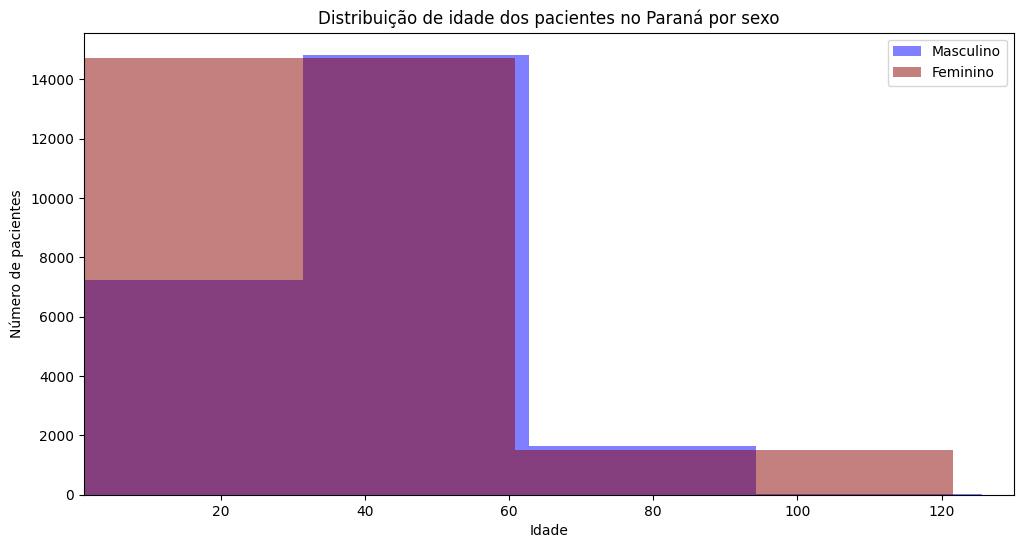

In [164]:
plt.figure(figsize=(12, 6))

plt.hist(idade_masc['idade'], bins=30, alpha=0.5, label='Masculino', color='blue')

plt.hist(idade_fem['idade'], bins=30, alpha=0.5, label='Feminino', color='darkred')

plt.xlabel('Idade')
plt.xlim(1, 130)
plt.ylabel('Número de pacientes')
plt.title('Distribuição de idade dos pacientes no Paraná por sexo')
plt.legend()
plt.show()

In [165]:
#informacao 11 - Gráfico comparando as idades das pessoas que realizaram exames no PARANÁ de acordo com a evolução do caso

**Em 1 único plot**

In [166]:
idade_evolucao = df.filter(df.estado == 'PARANÁ') \
  .select('evolucaoCaso', 'idade') \
  .toPandas()

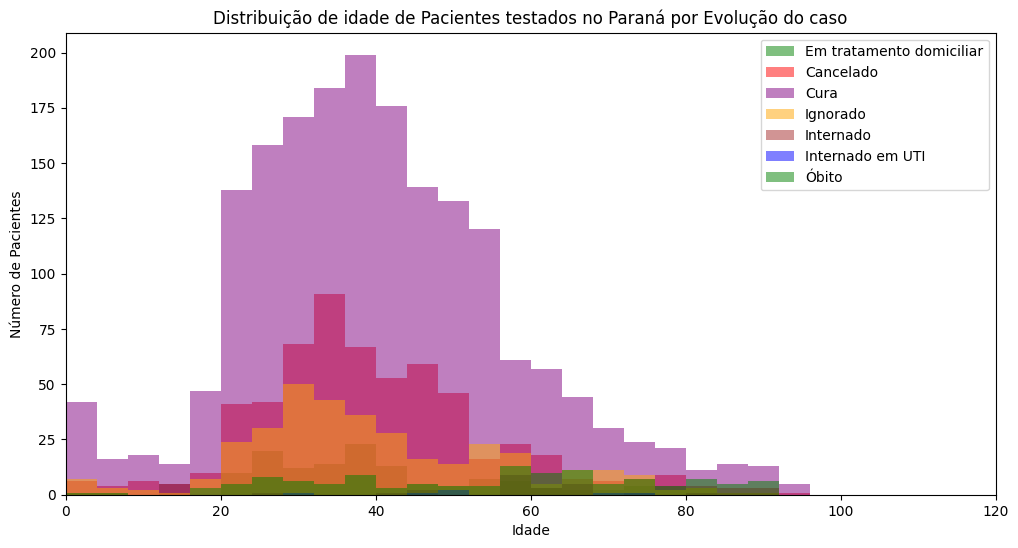

In [167]:
plt.figure(figsize=(12, 6))

categories = idade_evolucao['evolucaoCaso'].unique()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for i, category in enumerate(categories):
    category_ages = idade_evolucao[idade_evolucao['evolucaoCaso'] == category]['idade']

    plt.hist(category_ages, bins=30, alpha=0.5, label=category, color=colors[i % len(colors)], range=(0, 120))

plt.xlabel('Idade')
plt.ylabel('Número de Pacientes')
plt.title('Distribuição de idade de Pacientes testados no Paraná por Evolução do caso')
plt.legend()
plt.xlim(0, 120)
plt.show()


**Em plots separados**

In [168]:
idade_evolucao = df.filter(df.estado == 'PARANÁ') \
  .groupBy('evolucaoCaso') \
  .agg(func.collect_list('idade').alias('idades')) \
  .toPandas()

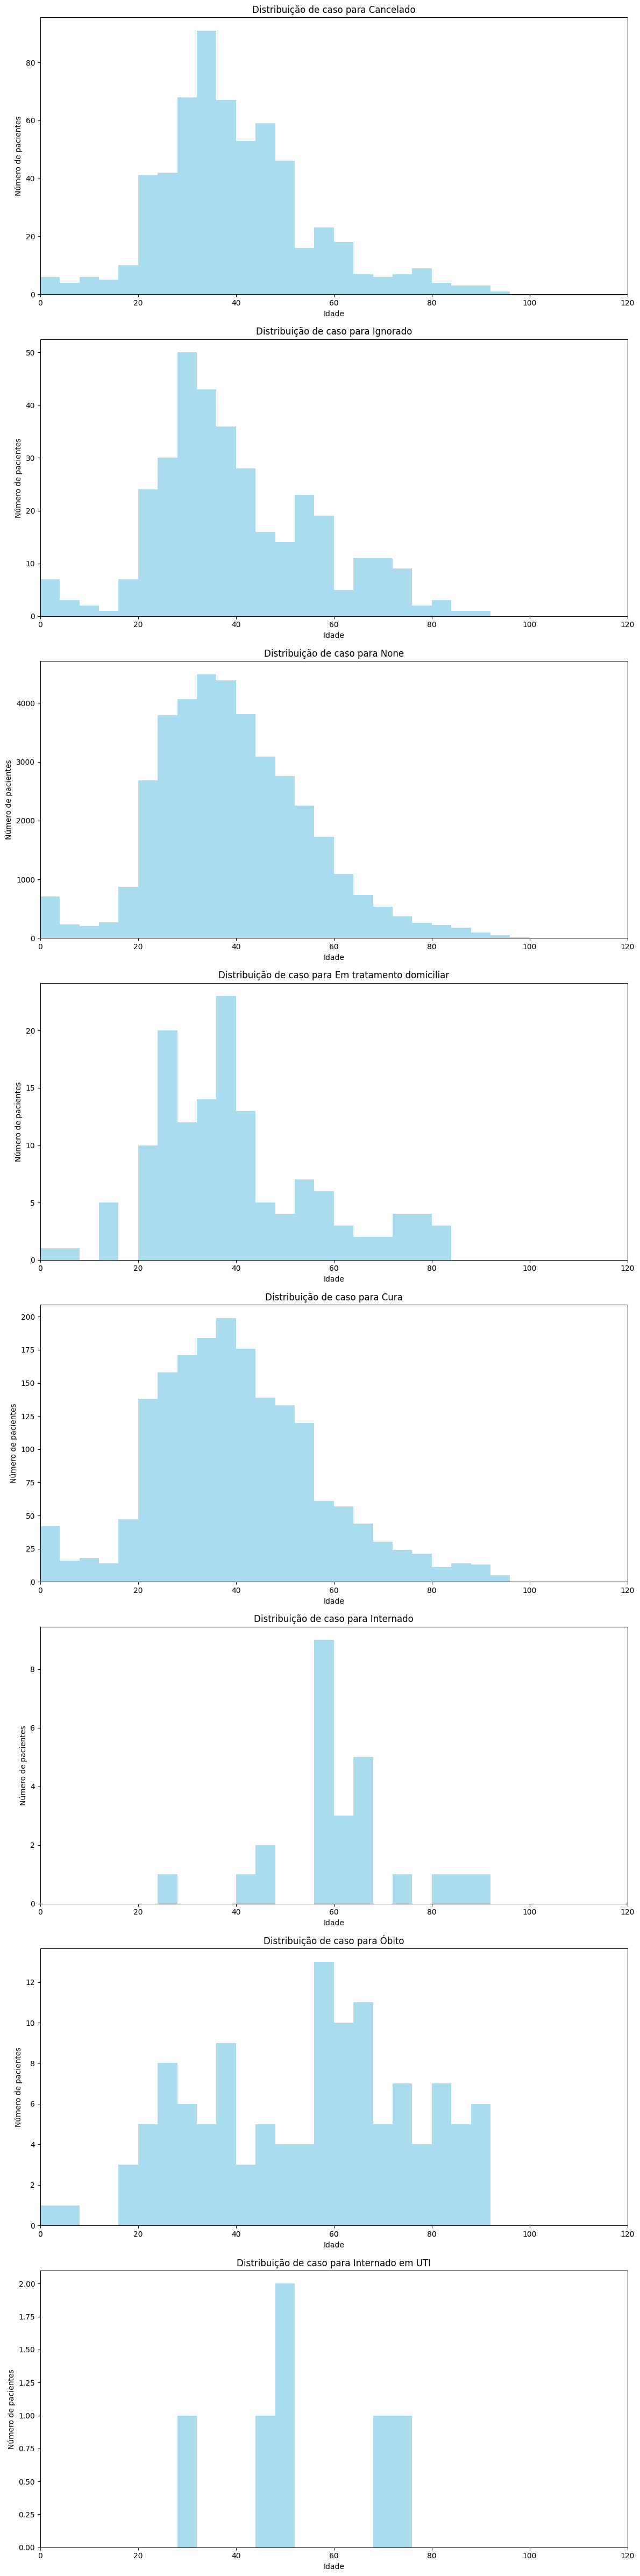

In [169]:
status = idade_evolucao.shape[0]

plt.figure(figsize=(12, 6 * status))

for i, row in idade_evolucao.iterrows():
    plt.subplot(status, 1, i+1)
    plt.hist(row['idades'], bins=30, alpha=0.7, range=(0, 120), color='skyblue')
    plt.title(f'Distribuição de caso para {row["evolucaoCaso"]}')
    plt.xlabel('Idade')
    plt.ylabel('Número de pacientes')
    plt.xlim(0, 120)

plt.tight_layout()
plt.show()